
# Semana 8 — Inferência com CNN salva (MNIST) 🔎🧠

Carregue o modelo **`cnn_mnist.pt`** e faça predições no conjunto de teste do **MNIST**.


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix


In [2]:

MODEL_PATH = "cnn_mnist.pt"
if not os.path.exists(MODEL_PATH):
    alt = "/mnt/data/cnn_mnist.pt"
    if os.path.exists(alt):
        MODEL_PATH = alt
print("Modelo:", MODEL_PATH if os.path.exists(MODEL_PATH) else "NÃO ENCONTRADO")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Modelo: cnn_mnist.pt


device(type='cpu')

In [3]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1   = nn.Linear(32*7*7, 128)
        self.fc_out= nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x)); x = self.pool(x)
        x = F.relu(self.conv2(x)); x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc_out(x)
        return x

model = SimpleCNN().to(device)

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("Não encontrei 'cnn_mnist.pt'. Treine e salve o modelo antes.")
state = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
"OK"


'OK'

In [4]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
test_ds  = datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)
len(test_ds)


10000

In [5]:

def eval_model(model, loader, device):
    model.eval()
    ys, yh = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            pred = logits.argmax(1).cpu().numpy()
            ys.append(yb.numpy()); yh.append(pred)
    y_true = np.concatenate(ys); y_pred = np.concatenate(yh)
    return y_true, y_pred

y_true, y_pred = eval_model(model, test_loader, device)
acc = (y_true == y_pred).mean()
print(f"Acurácia teste: {acc:.4f}")
print("\nRelatório:\n", classification_report(y_true, y_pred, digits=4))


/Users/yandrade/PycharmProjects/ia_study/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Acurácia teste: 0.9898

Relatório:
               precision    recall  f1-score   support

           0     0.9819    0.9980    0.9899       980
           1     0.9965    0.9974    0.9969      1135
           2     0.9941    0.9855    0.9898      1032
           3     0.9882    0.9941    0.9911      1010
           4     0.9928    0.9857    0.9893       982
           5     0.9865    0.9865    0.9865       892
           6     0.9958    0.9875    0.9916       958
           7     0.9941    0.9893    0.9917      1028
           8     0.9857    0.9887    0.9872       974
           9     0.9812    0.9841    0.9827      1009

    accuracy                         0.9898     10000
   macro avg     0.9897    0.9897    0.9897     10000
weighted avg     0.9898    0.9898    0.9898     10000



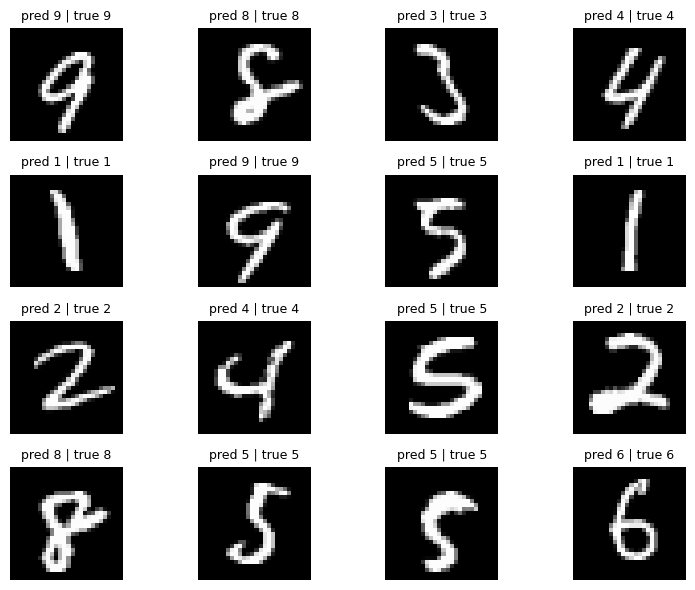

In [6]:

# Grid aleatório de predições
N = 16
idx = np.random.choice(len(test_ds), size=N, replace=False)
fig = plt.figure(figsize=(8,6))
for i, k in enumerate(idx, 1):
    img, target = test_ds[k]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
    ax = plt.subplot(4,4,i)
    plt.imshow(img.squeeze().numpy(), cmap="gray")
    plt.title(f"pred {pred} | true {target}", fontsize=9)
    plt.axis("off")
plt.tight_layout(); plt.show()


In [7]:

# Erros mais comuns
cm = confusion_matrix(y_true, y_pred)
cm_off = cm.copy().astype(float)
np.fill_diagonal(cm_off, 0)
pairs = [((i,j), int(cm_off[i,j])) for i in range(10) for j in range(10) if i!=j and cm_off[i,j]>0]
pairs = sorted(pairs, key=lambda x: x[1], reverse=True)
pairs[:10]


[((4, 9), 12),
 ((5, 3), 9),
 ((2, 0), 7),
 ((7, 2), 6),
 ((3, 5), 5),
 ((6, 0), 5),
 ((9, 4), 4),
 ((9, 5), 4),
 ((9, 8), 4),
 ((1, 8), 3)]

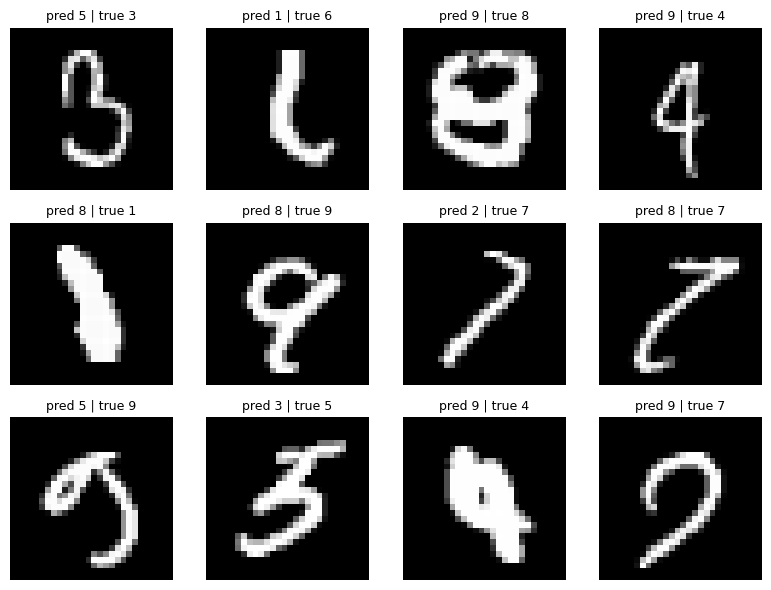

(102, 'erros exibidos:', 12)

In [8]:

# Exibir alguns erros
miss = np.where(y_true != y_pred)[0]
np.random.shuffle(miss)
show = miss[:12]
fig = plt.figure(figsize=(8,6))
for i, k in enumerate(show, 1):
    img, target = test_ds[k]
    pred = y_pred[k]
    ax = plt.subplot(3,4,i)
    plt.imshow(img.squeeze().numpy(), cmap="gray")
    plt.title(f"pred {pred} | true {target}", fontsize=9)
    plt.axis("off")
plt.tight_layout(); plt.show()
len(miss), "erros exibidos:", len(show)
